In [66]:
import tensorflow as tf
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
# Tentukan path ke direktori dataset
dataset_dir = '/content/drive/MyDrive/Dataset/Rumah Adat'

# Daftar direktori yang berisi data TRAIN, TEST, dan PENGUJIAN
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
val_dir = os.path.join(dataset_dir, 'val')

In [69]:
# Persiapkan data dengan menggunakan ImageDataGenerator
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

In [70]:
# Parameter
batch_size = 32
img_size = (128, 128)

In [71]:
# Data Augmentation untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [72]:
# Rescale untuk validation dan test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [73]:
# Generator untuk data training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Generator untuk data validasi
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Generator untuk data test
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 7032 images belonging to 5 classes.
Found 1505 images belonging to 5 classes.
Found 1511 images belonging to 5 classes.


In [74]:
base_model = tf.keras.applications.MobileNet(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(128, 128, 3),
    pooling='avg'
)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [75]:
# Model MobileNet pre-trained
base_model = tf.keras.applications.MobileNet(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(128, 128, 3),  # Ukuran gambar (resolusi)
    pooling='avg'  # Pooling rata-rata
)

# Menambahkan layer klasifikasi di atas MobileNet
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Dense(5, activation='softmax'),  # Jumlah kelas = 5
])


In [77]:
# Membekukan layer agar tidak terupdate saat pelatihan
for layer in base_model.layers:
    layer.trainable = False

In [78]:
# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [79]:
# Tempat menyimpan model terbaik
model_checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Dataset/inception_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

In [80]:
# Pelatihan model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[model_checkpoint]
)

Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - accuracy: 0.8001 - loss: 0.5690
Epoch 1: val_accuracy improved from -inf to 0.97940, saving model to /content/drive/MyDrive/Dataset/inception_model.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - accuracy: 0.8006 - loss: 0.5676 - val_accuracy: 0.9794 - val_loss: 0.0731
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.9820 - loss: 0.0676
Epoch 2: val_accuracy improved from 0.97940 to 0.99136, saving model to /content/drive/MyDrive/Dataset/inception_model.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.9820 - loss: 0.0676 - val_accuracy: 0.9914 - val_loss: 0.0482
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - accuracy: 0.9882 - loss: 0.0469
Epoch 3: val_accuracy improved from 0.99136 to 0.99336, saving model to /content/drive/MyDrive/Dataset/inception_model.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.9882 - loss: 0.0469 - val_accuracy: 0.9934 - val_loss: 0.0409
Epoch 4/10

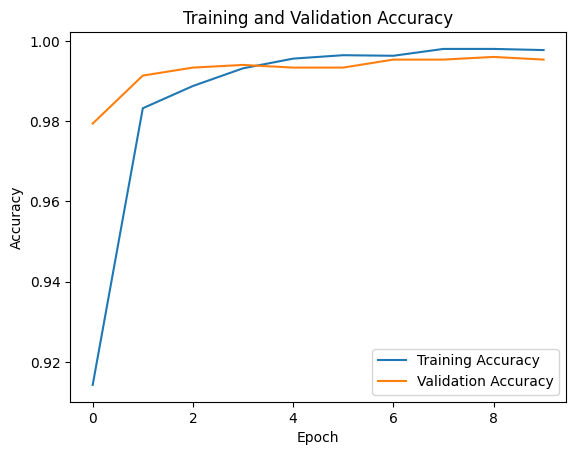

In [81]:
# Tampilkan grafik akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

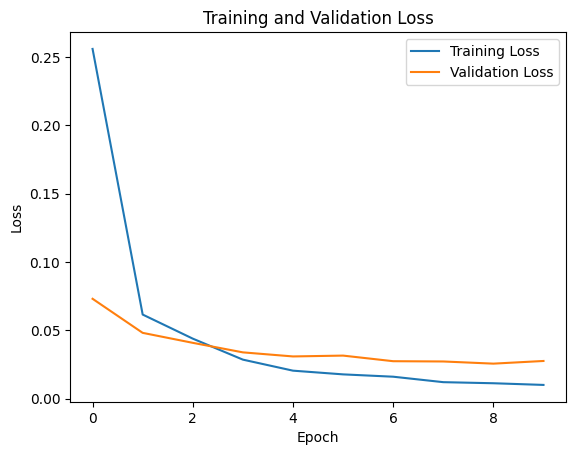

In [82]:
# Tampilkan grafik loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [83]:
# Memuat model terbaik
best_model = keras.models.load_model('/content/drive/MyDrive/Dataset/inception_model.keras')

In [84]:
# Evaluasi model menggunakan data test
test_loss, test_acc = best_model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

1511/1511 ━━━━━━━━━━━━━━━━━━━━ 51s 32ms/step - accuracy: 0.9959 - loss: 0.0127
Test accuracy: 0.9966909289360046


In [85]:
# Ambil true classes
y_true = test_generator.classes

# Ubah kelas menjadi nama kelas
class_labels = list(test_generator.class_indices.keys())

# Prediksi kelas
y_pred = best_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

if len(y_true) == len(y_pred_classes):
    # classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_labels))
else:
    print("Error: Number of samples in y_true and y_pred_classes are not consistent.")

1511/1511 ━━━━━━━━━━━━━━━━━━━━ 53s 35ms/step
Classification Report:
              precision    recall  f1-score   support

      gadang       1.00      0.99      1.00       294
       honai       1.00      1.00      1.00       309
       joglo       0.99      0.99      0.99       324
     panjang       0.99      1.00      0.99       282
   tongkonan       1.00      1.00      1.00       302

    accuracy                           1.00      1511
   macro avg       1.00      1.00      1.00      1511
weighted avg       1.00      1.00      1.00      1511

